# Regression using a piecewise kernel

This notebook explains how to use Piecewise kernels in Markovflow models.

We focus on the Sparse Variational Gaussian Process model.

Our probabilistic model for this data is:
$$
\begin{align}
f \sim \mathcal{GP}(0, k(., .)) \\
y_i \sim f(x_i) + \mathcal{N}(0, \epsilon^2)
\end{align}
$$


**NOTE:** If you have difficulty running this notebook, consider clearing the output and then restarting the kernel.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Setup

import warnings

# Turn off warnings
warnings.simplefilter('ignore')

from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import gpflow

from gpflow import default_float, set_trainable
from gpflow.ci_utils import ci_niter
from gpflow.likelihoods import Gaussian

from markovflow.models.sparse_variational import SparseVariationalGaussianProcess
from markovflow.kernels import Matern52
from markovflow.kernels import PiecewiseKernel
from markovflow.ssm_natgrad import SSMNaturalGradient
FLOAT_TYPE = default_float()

# uncomment in notebook
# try:
#     from IPython import get_ipython
#     get_ipython().run_line_magic('matplotlib', 'inline')
# except AttributeError:
#     print('Magic function can only be used in IPython environment')
#     matplotlib.use('Agg')

plt.rcParams["figure.figsize"] = [15, 8]

2022-09-17 15:51:02.054012: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:51:02.054049: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Step 1: Generate training data

First, let's generate a frequency modulated wave form.

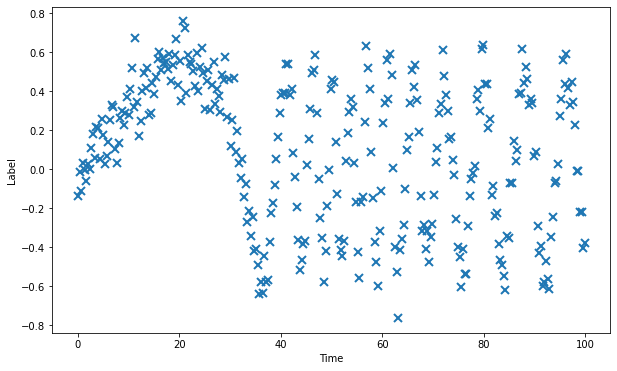

In [3]:
def create_observations(time_points: np.ndarray) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    A helper function to create training data.
    :param time_points: Time points to generate observations for.
    :return: Tuple[x,y] Data that represents the observations' shapes:
        X = [num_points, 1],
        Y = [num_points, state_dim , 1] where state_dim is currently 1
    """
    omega_ = np.exp((time_points - 50.) / 6.) / (1. + np.exp((time_points - 50.) / 6.)) + 0.1
    y = (np.cos(time_points * omega_ / 3) * np.sin(time_points * omega_ / 3)).reshape(-1, 1)
    return time_points, y + np.random.randn(*y.shape) * .1

# Generate some observations
N = 300
time_points, observations = create_observations(np.linspace(0, 100, N))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(time_points, observations, 'C0x', ms=8, mew=2)
plt.xlabel("Time")
plt.ylabel("Label")
plt.show()
plt.close()

## Step 2: Build a Piecewise kernel

In [4]:
num_inducing = 30
step_z = N // num_inducing
num_change_points = 5
step_c = num_inducing // num_change_points

# What happens if you don't choose your inducing points from your data
inducing_points = time_points[::step_z]
inducing_points = np.linspace(np.min(time_points), np.max(time_points), num_inducing)

# What happens if you don't choose your change points from your inducing points
change_points = inducing_points[::step_c]
change_points = np.linspace(np.min(time_points), np.max(time_points), num_change_points)

assert num_change_points == len(change_points)

base = Matern52
state_dim = 3
variances = np.array([1.] * (num_change_points + 1))
lengthscales = np.array([4.] * (num_change_points + 1))

ks = [base(variance=variances[l],
            lengthscale=lengthscales[l])
      for l in range(num_change_points + 1)]

# Set state mean trainable
[k.set_state_mean(tf.zeros(state_dim,), trainable=True) for k in ks]

kernel = PiecewiseKernel(
    ks, tf.convert_to_tensor(change_points, dtype=default_float()))

2022-09-17 15:51:03.764431: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-09-17 15:51:03.764627: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.13/x64/lib
2022-09-17 15:51:03.764638: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-17 15:51:03.764656: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az178-774): /proc/driver/nvidia/version does not exist
2022-09-17 15:51:03.764900: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F F

## Step 3: Build and optimise a model

In [5]:
# Create a likelihood object
bernoulli_likelihood = Gaussian()

s2vgp = SparseVariationalGaussianProcess(
    kernel=kernel,
    inducing_points=tf.convert_to_tensor(inducing_points, dtype=default_float()),
    likelihood=bernoulli_likelihood
)

# equivalent to loss = -vgpc.elbo()
input_data = (time_points, observations)
loss = s2vgp.loss(input_data)

# Before optimisation, calculate the loss of the observations given the current kernel parameters
print("Loss before optimisation: ", loss.numpy())

Loss before optimisation:  447.3254994314457


2022-09-17 15:51:04.174618: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2022-09-17 15:51:41.857911: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-09-17 15:51:41.858373: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2793435000 Hz


Iteration: 0 , Loss: 316.48121407177354


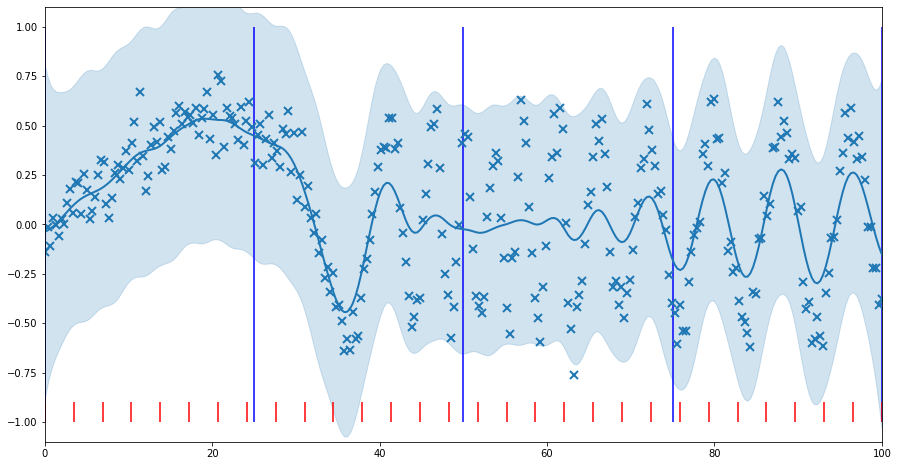

Iteration: 10 , Loss: 311.41395165313884


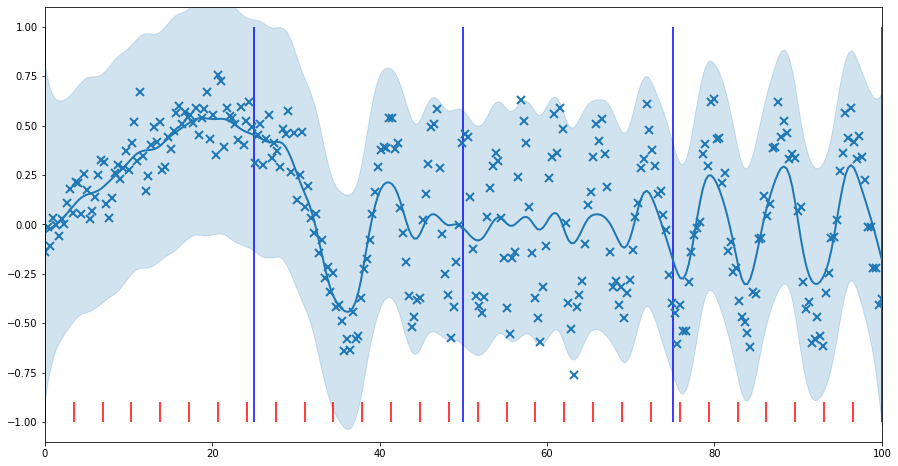

Iteration: 20 , Loss: 306.5121307926455


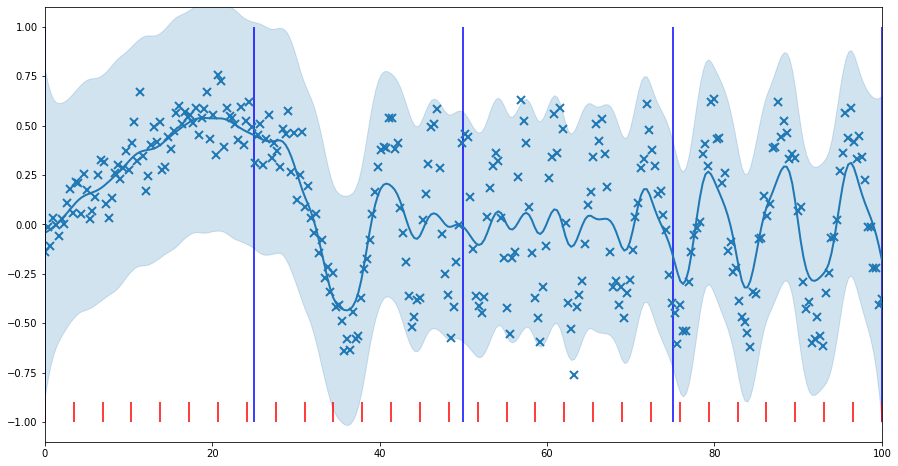

Iteration: 30 , Loss: 301.60126848384016


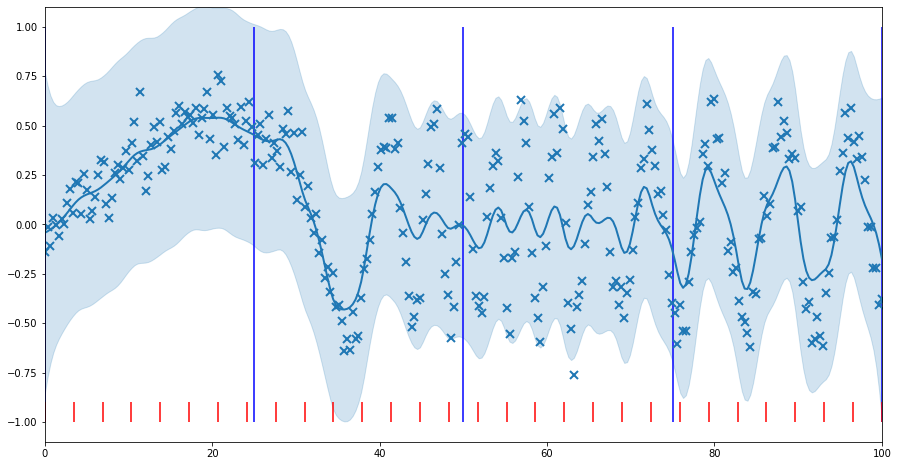

Iteration: 40 , Loss: 296.66110968144653


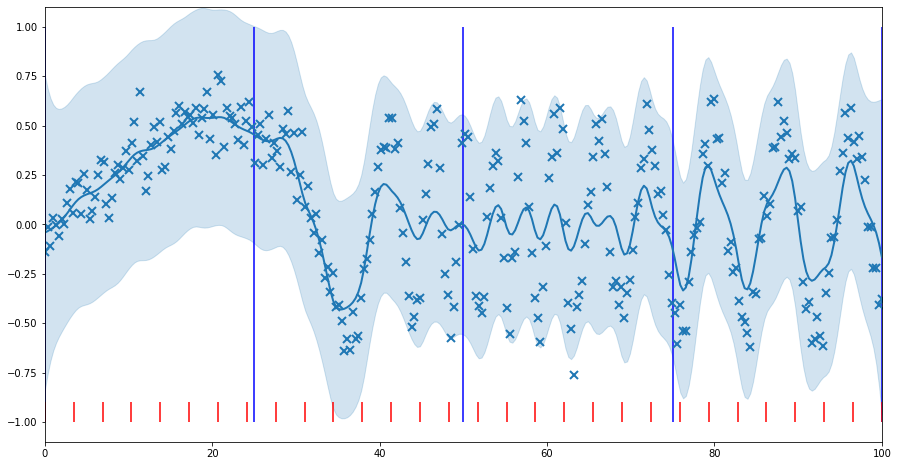

Iteration: 50 , Loss: 291.67944022933386


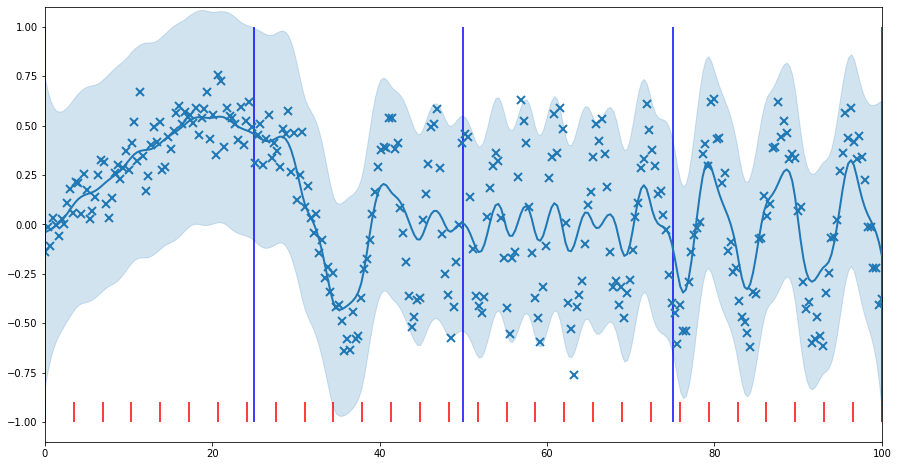

Iteration: 60 , Loss: 286.65316373860423


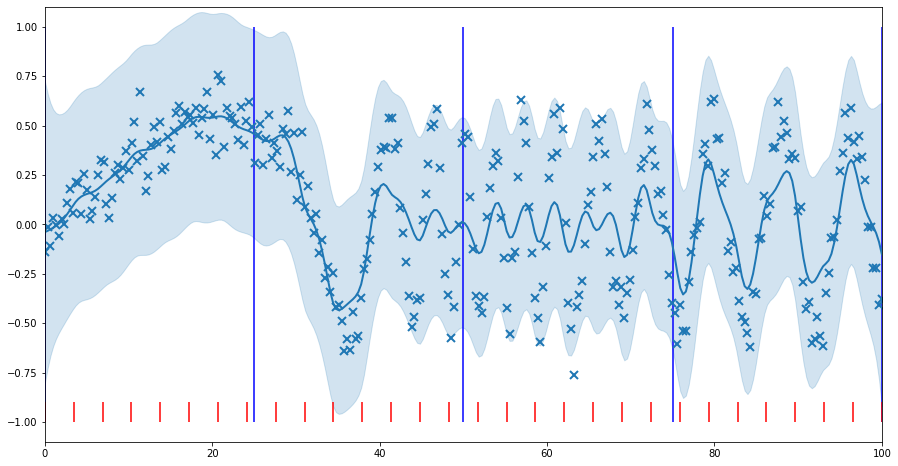

Iteration: 70 , Loss: 281.5812215891556


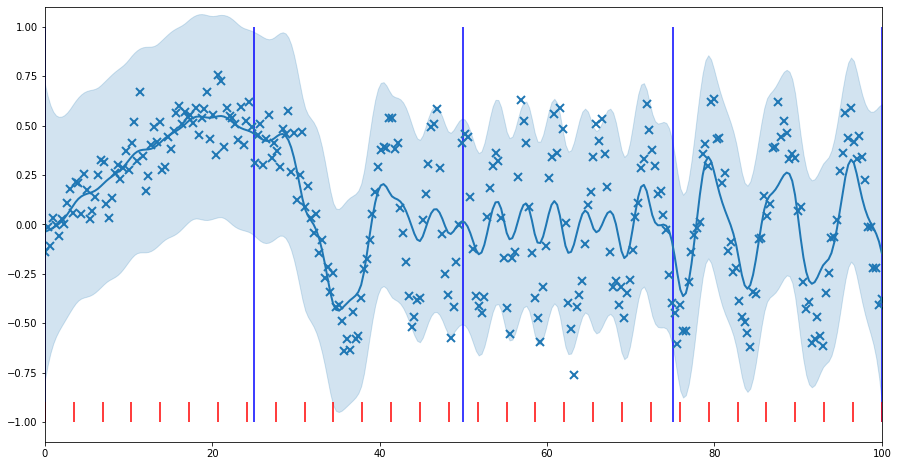

Iteration: 80 , Loss: 276.46211834870815


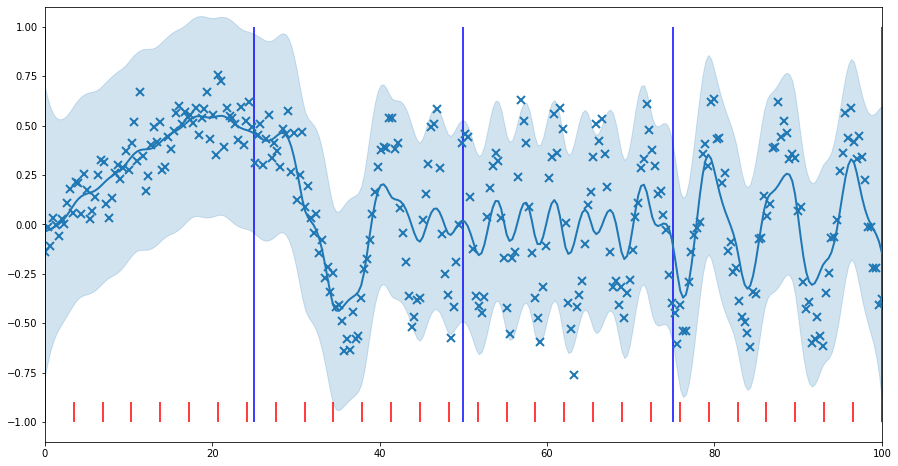

Iteration: 90 , Loss: 271.29412214535876


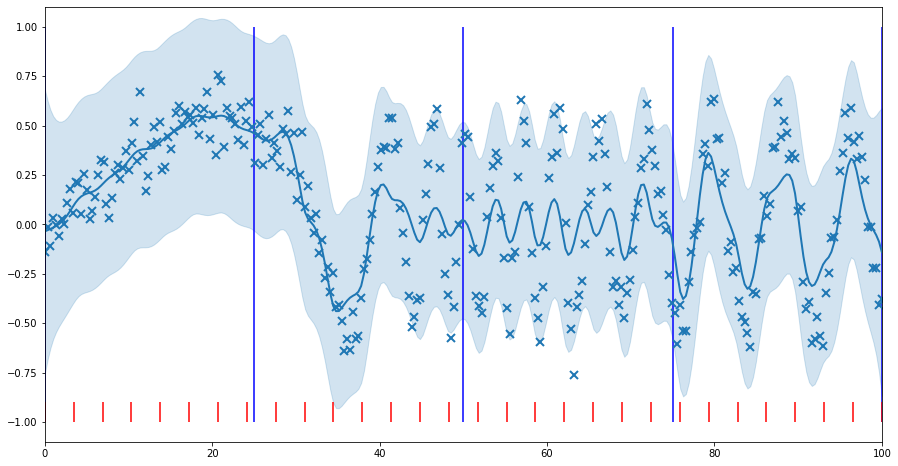

Iteration: 100 , Loss: 266.0758733983721


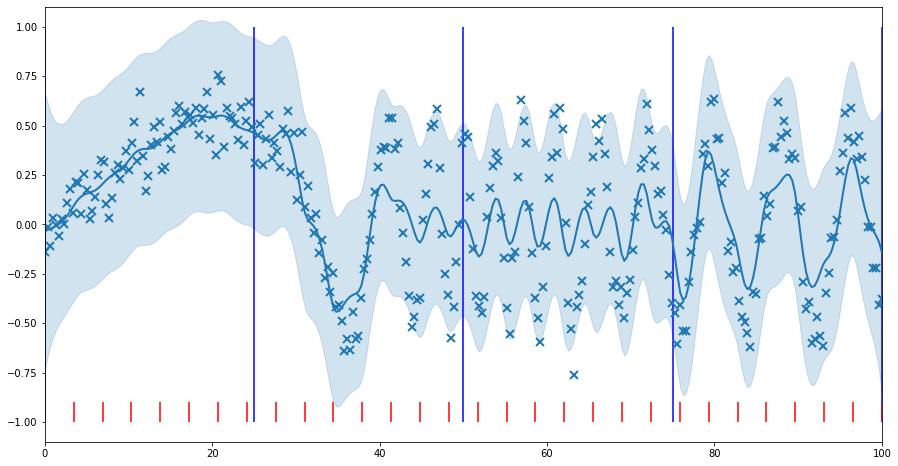

Iteration: 110 , Loss: 260.80700595251994


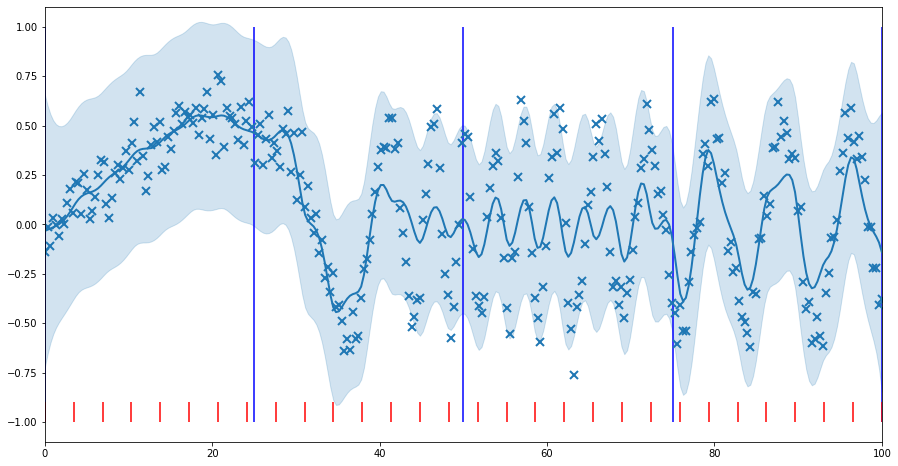

Iteration: 120 , Loss: 255.48827315589872


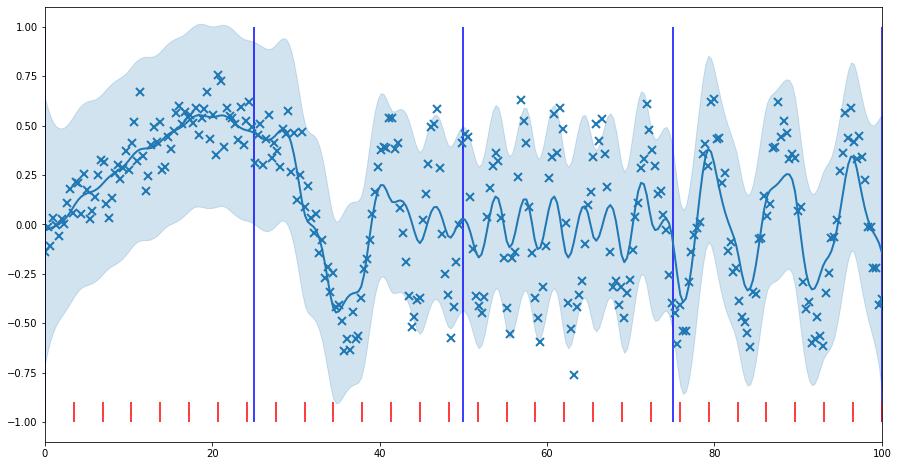

Iteration: 130 , Loss: 250.12139105157087


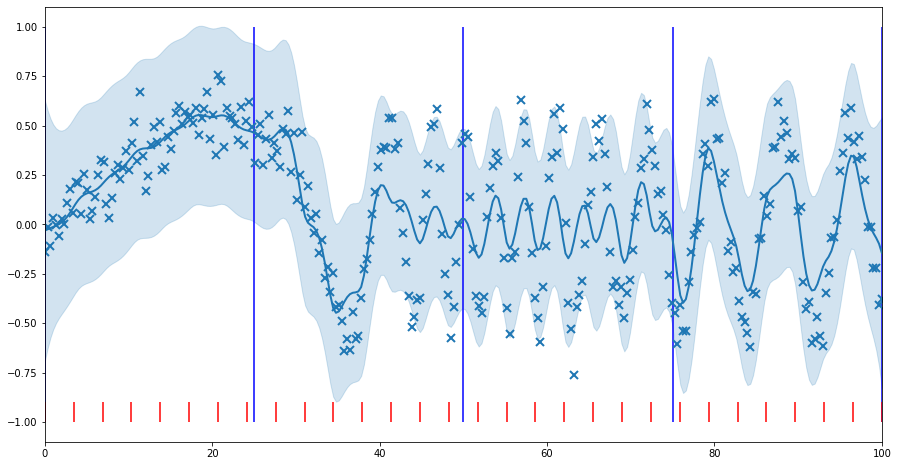

Iteration: 140 , Loss: 244.7087704962197


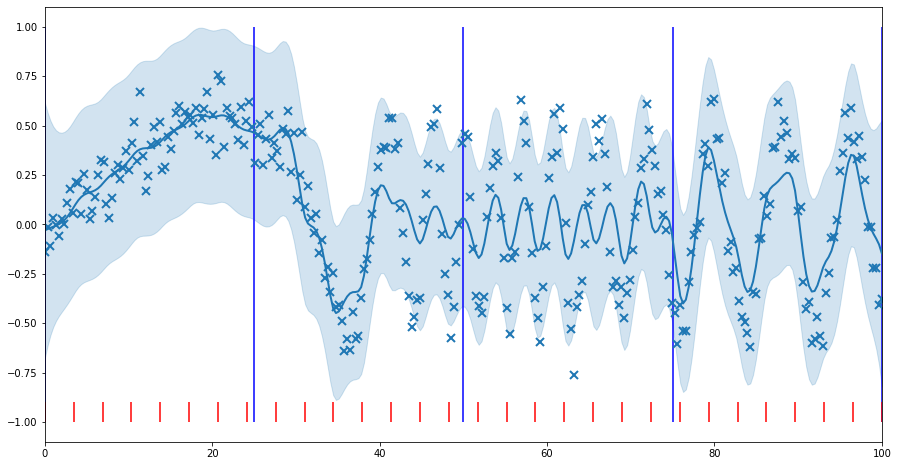

Iteration: 150 , Loss: 239.25333065700448


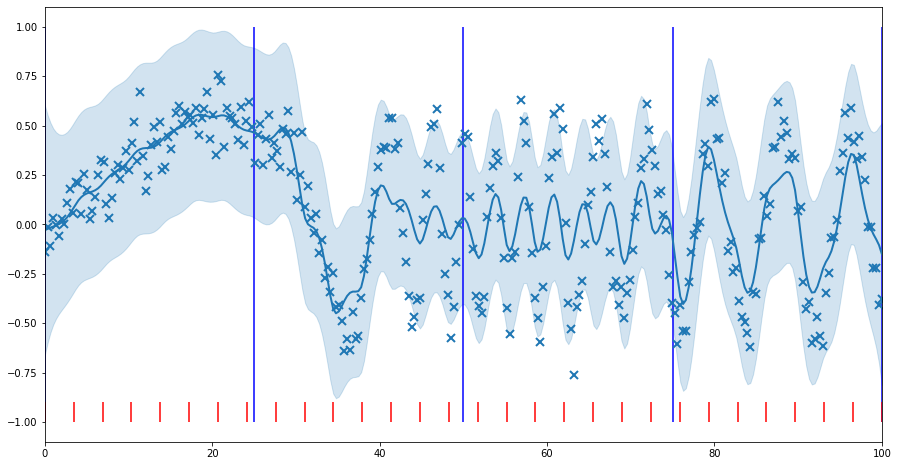

Iteration: 160 , Loss: 233.75838202678153


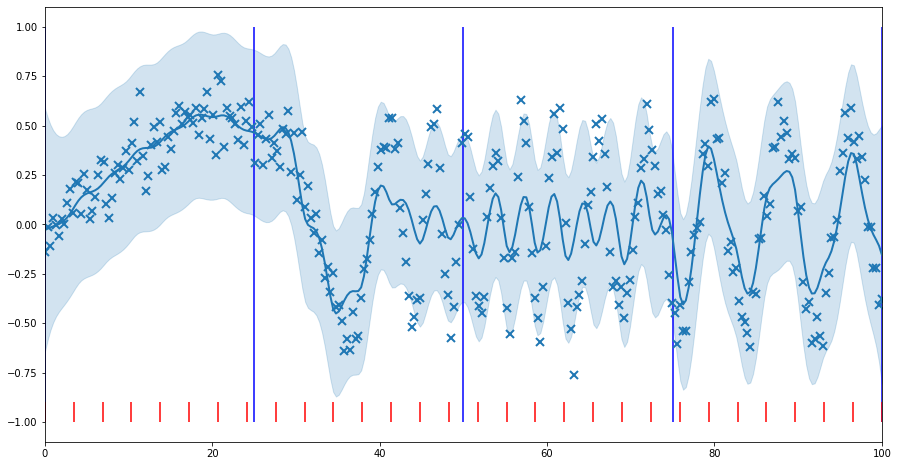

Iteration: 170 , Loss: 228.22756254888898


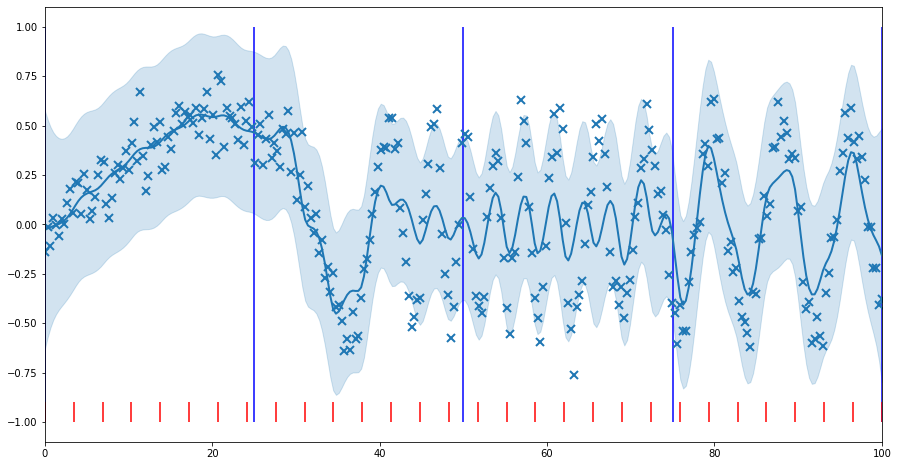

Iteration: 180 , Loss: 222.66480143562507


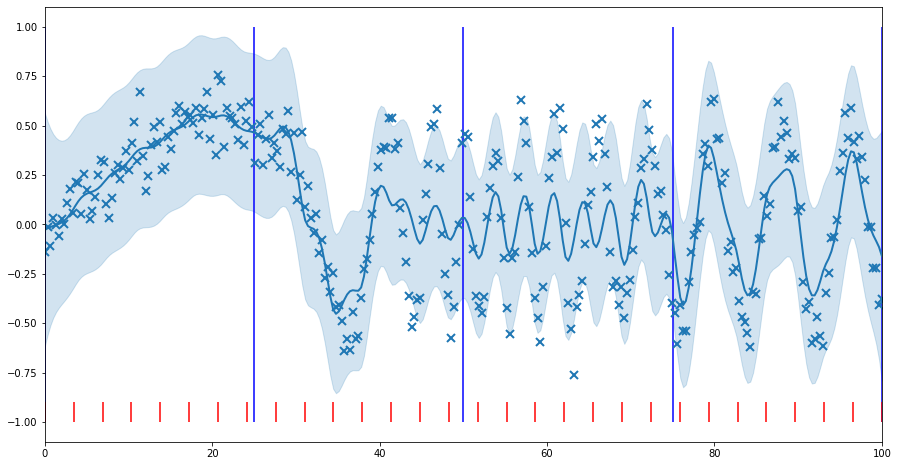

Iteration: 190 , Loss: 217.07429836183192


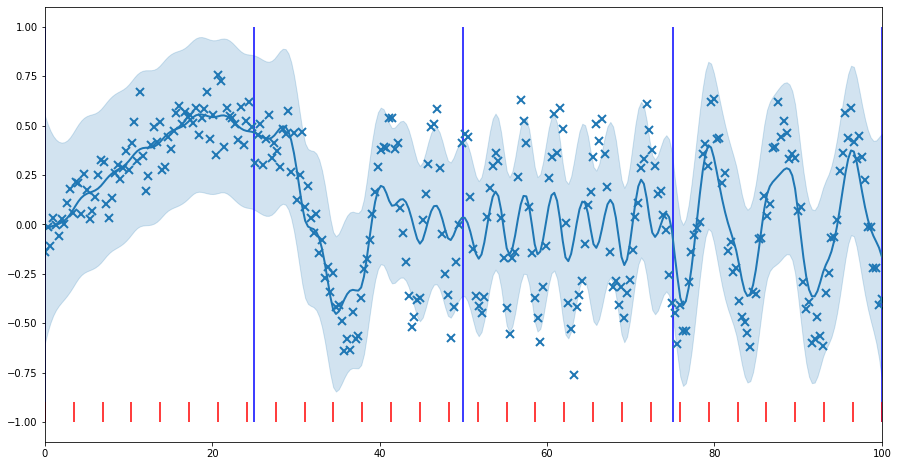

Iteration: 200 , Loss: 211.46050808930363


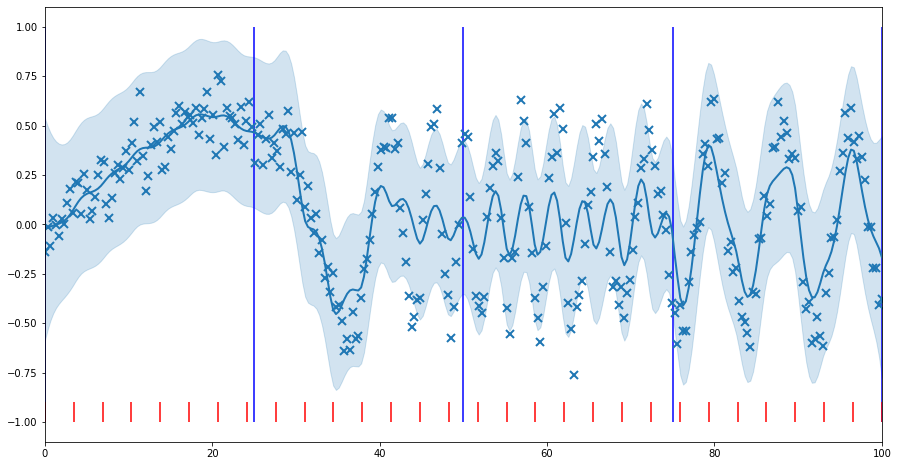

Iteration: 210 , Loss: 205.82812713588945


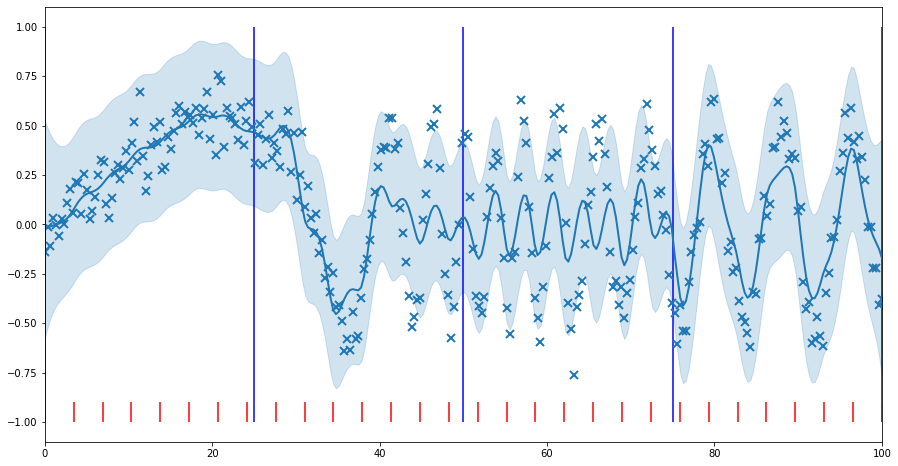

Iteration: 220 , Loss: 200.1964052960365


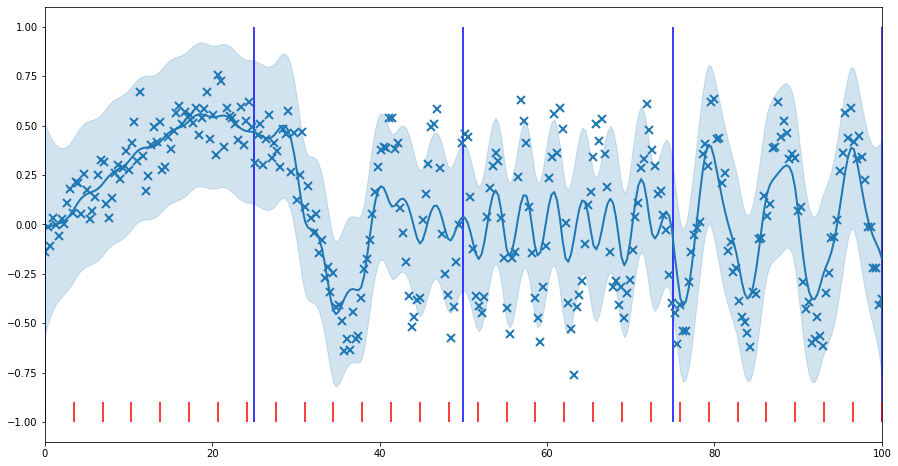

Iteration: 230 , Loss: 194.5274992441604


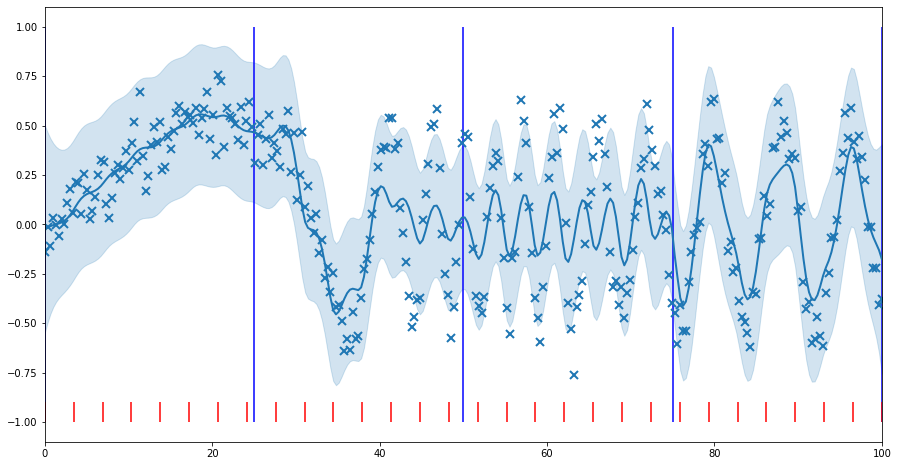

Iteration: 240 , Loss: 188.8697076756959


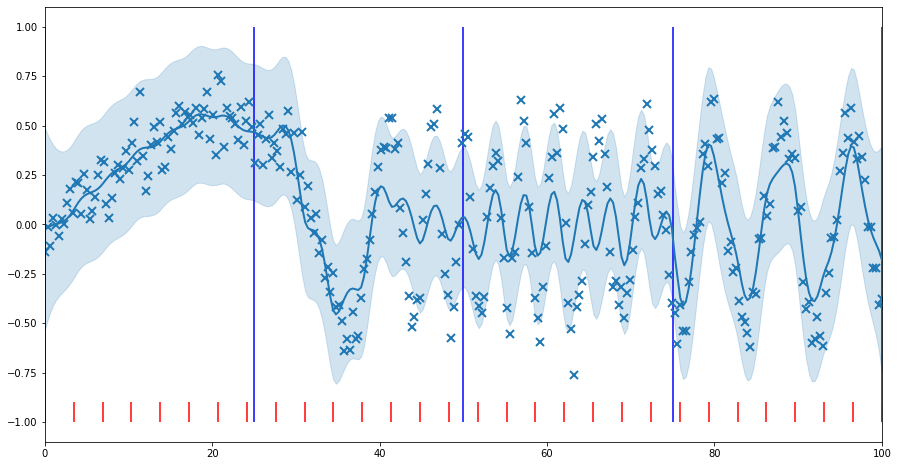

Iteration: 250 , Loss: 183.21418993696676


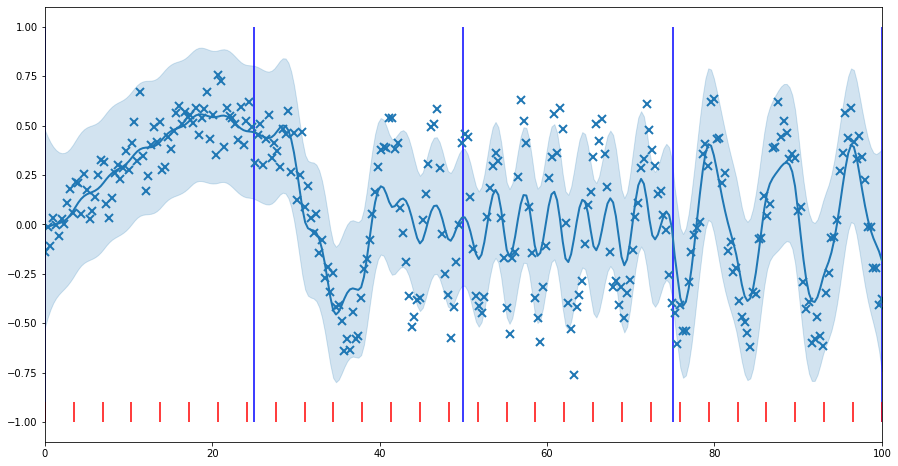

Iteration: 260 , Loss: 177.56660146415135


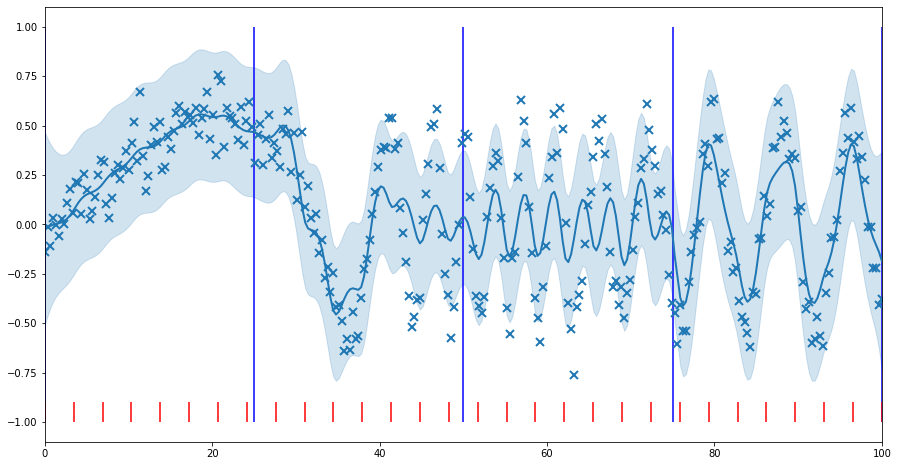

Iteration: 270 , Loss: 171.9342211297267


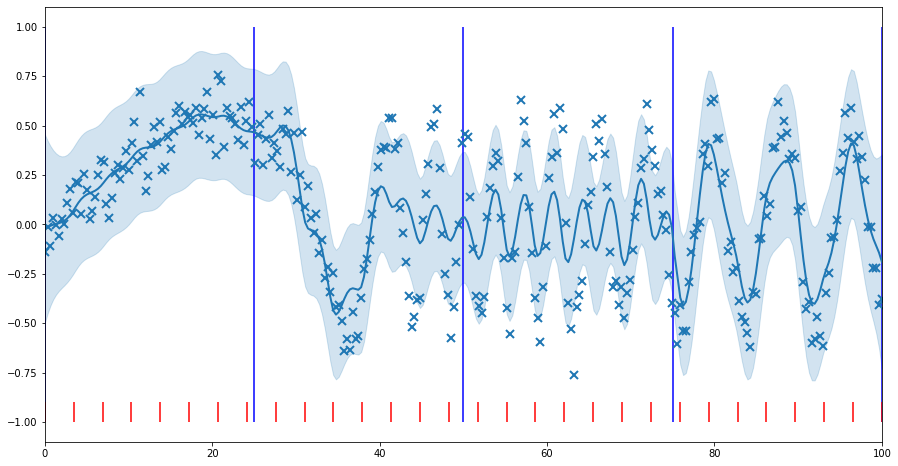

Iteration: 280 , Loss: 166.3179655675469


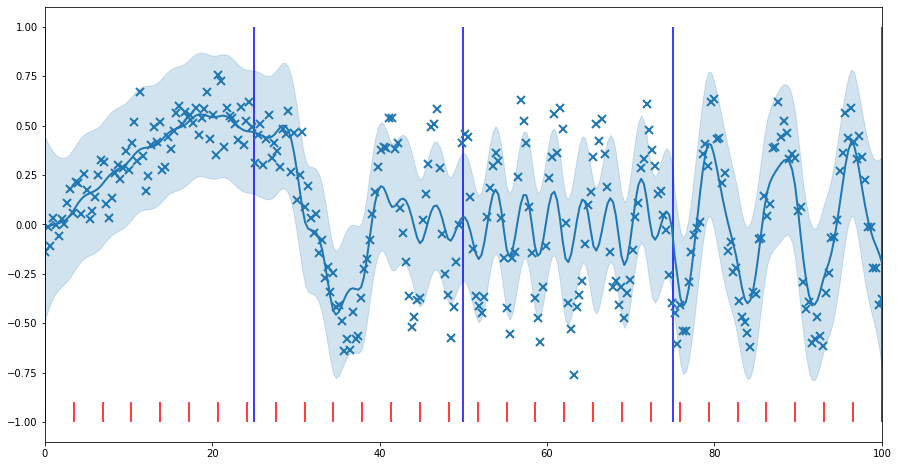

Iteration: 290 , Loss: 160.72855958812212


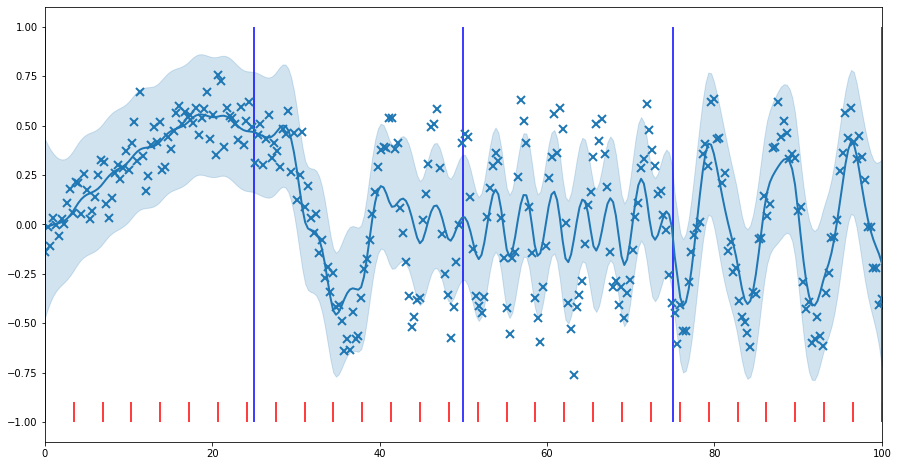

Iteration: 300 , Loss: 155.17140266422572


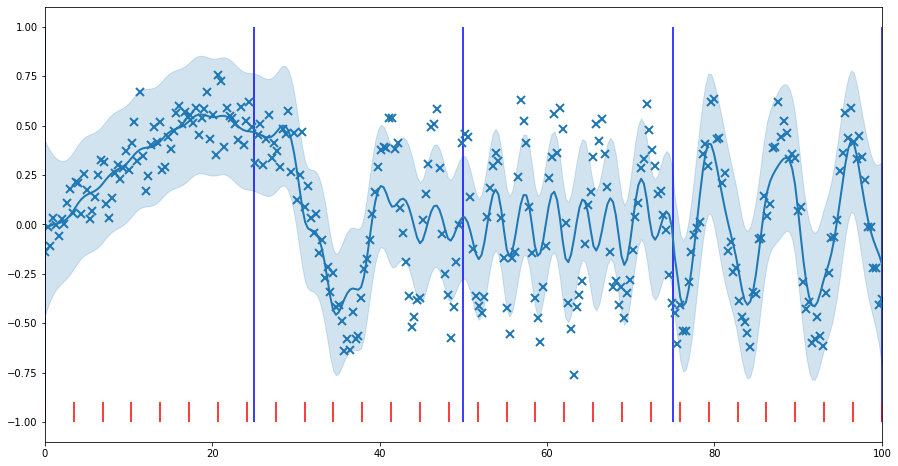

Iteration: 310 , Loss: 149.65367797690644


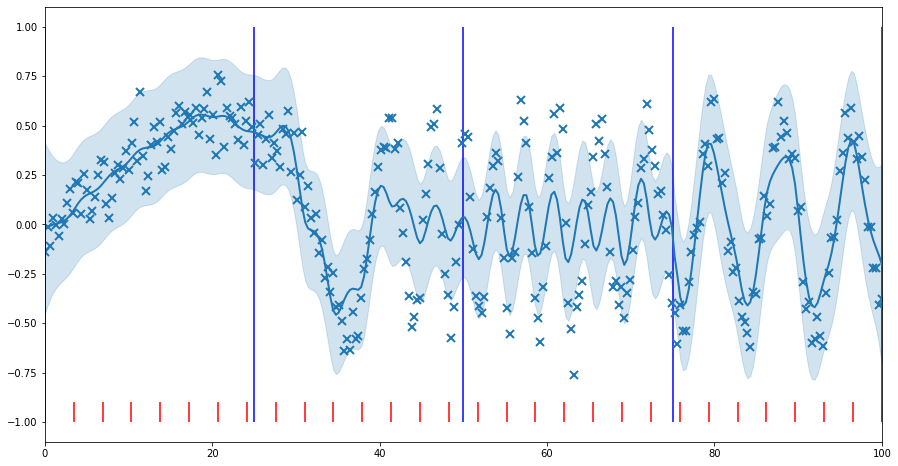

Iteration: 320 , Loss: 144.16811541140817


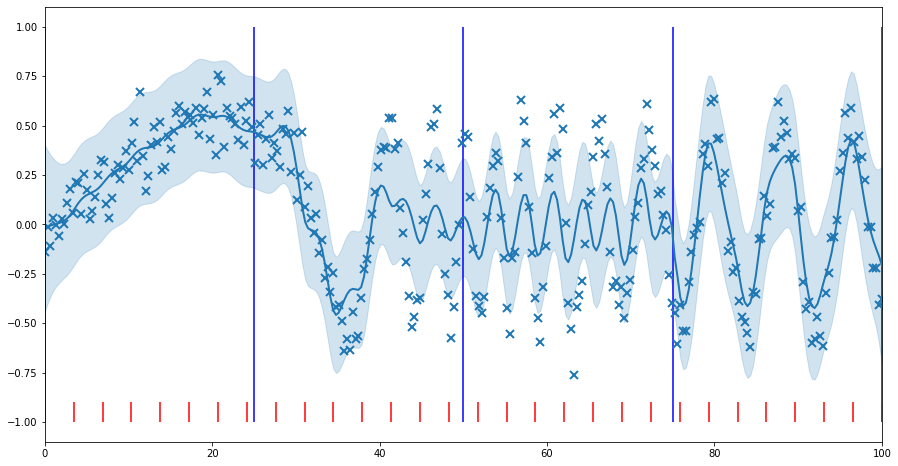

Iteration: 330 , Loss: 138.73535029367162


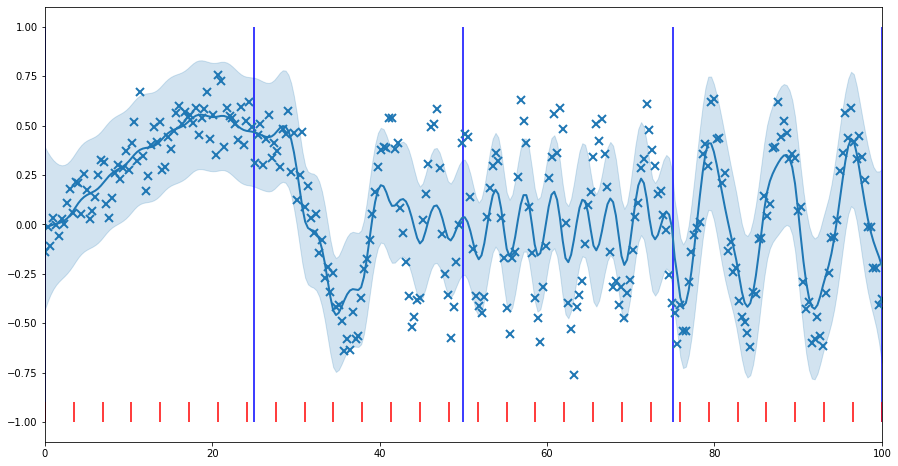

Iteration: 340 , Loss: 133.35654309660904


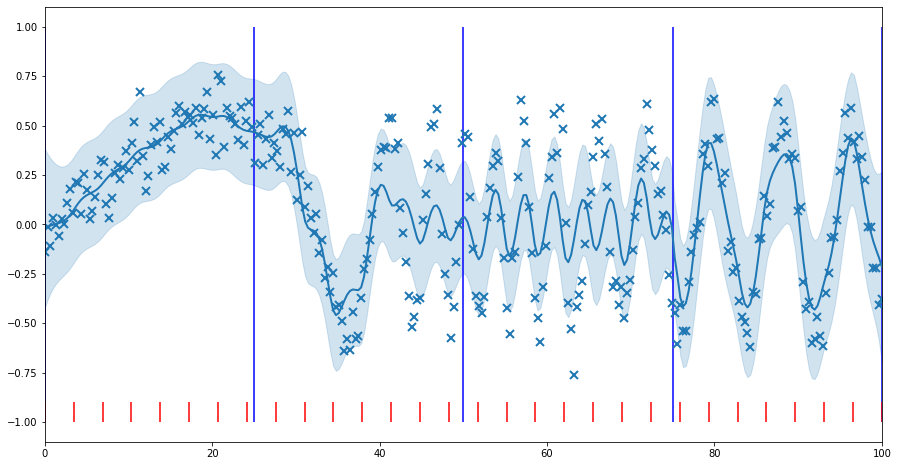

Iteration: 350 , Loss: 128.03368053668186


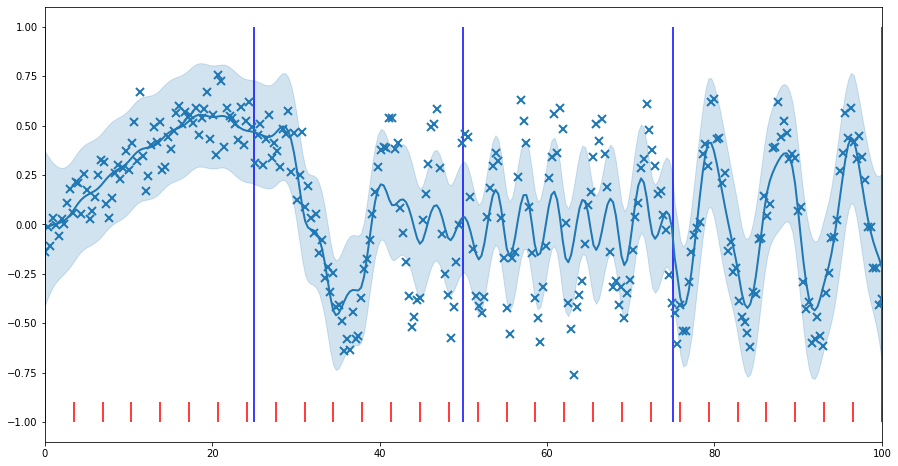

Iteration: 360 , Loss: 122.76734239484284


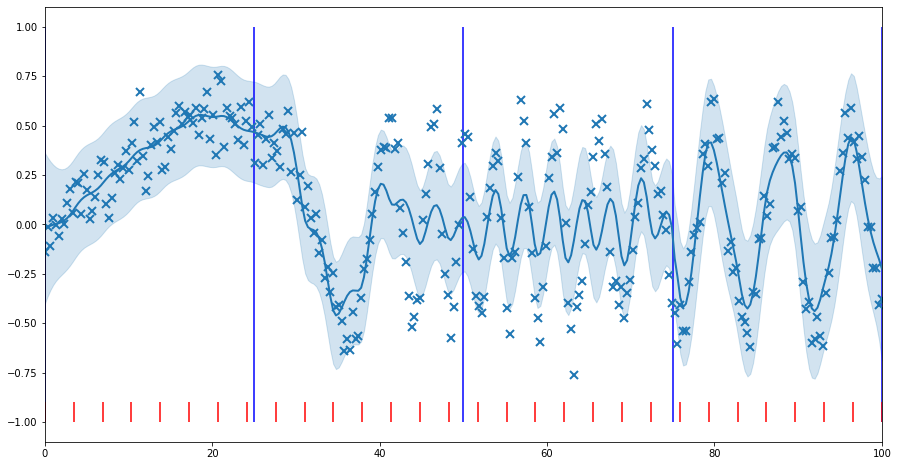

Iteration: 370 , Loss: 117.56711170428748


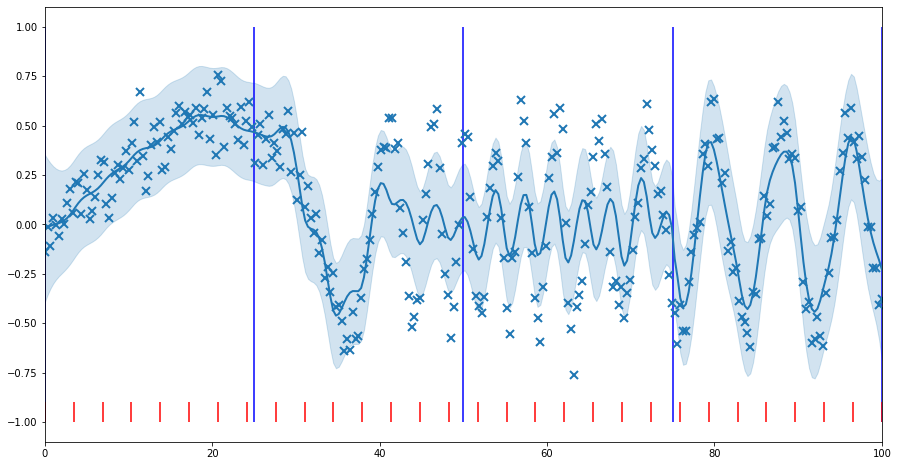

Iteration: 380 , Loss: 112.44075175911198


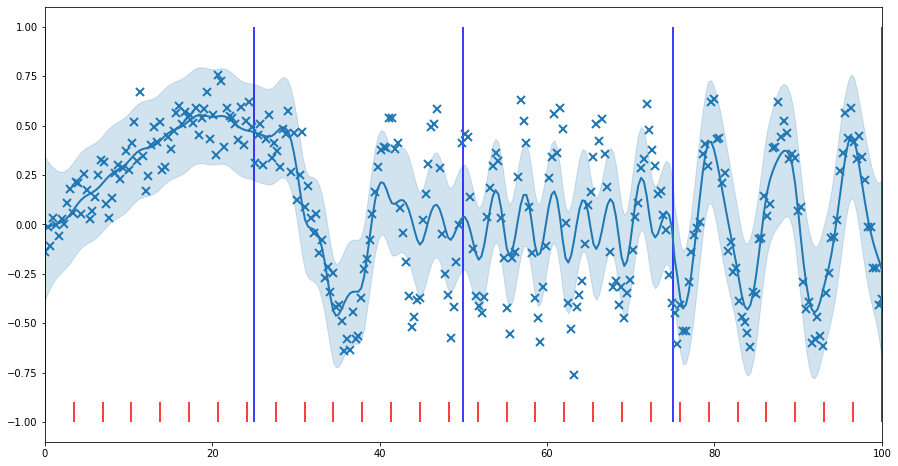

Iteration: 390 , Loss: 107.36388144914186


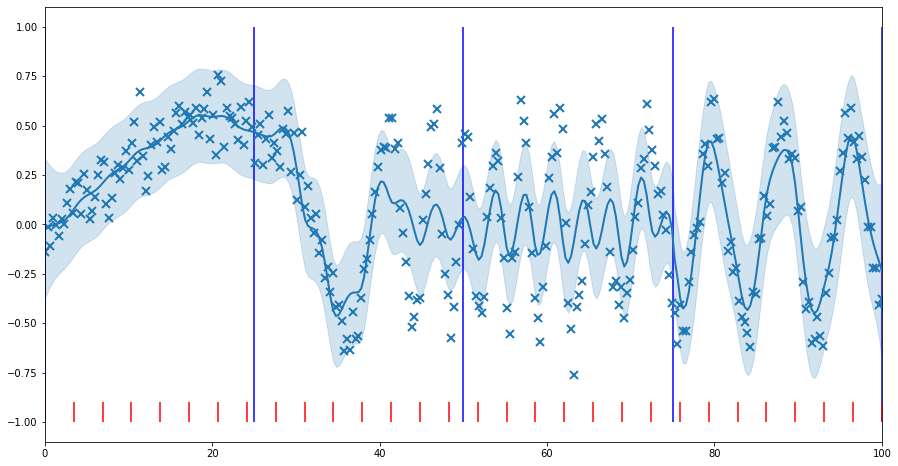

Iteration: 400 , Loss: 102.35963533996237


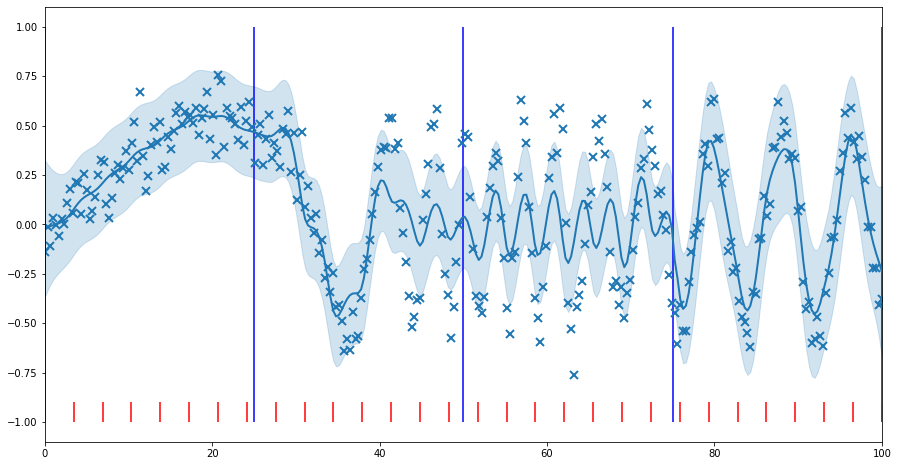

Iteration: 410 , Loss: 97.42035593446765


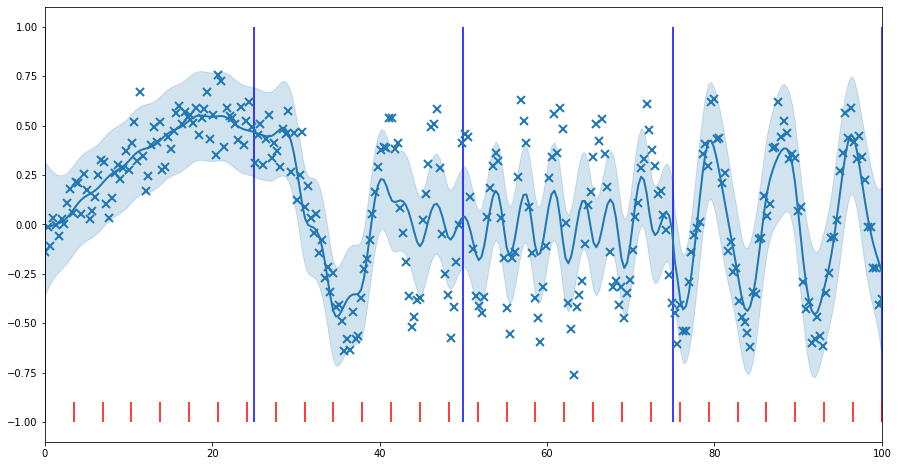

Iteration: 420 , Loss: 92.54382335086257


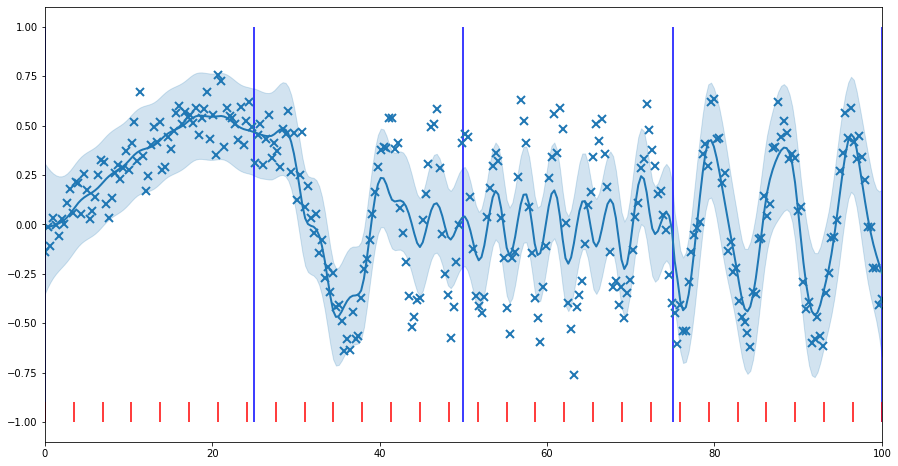

Iteration: 430 , Loss: 87.70388786433914


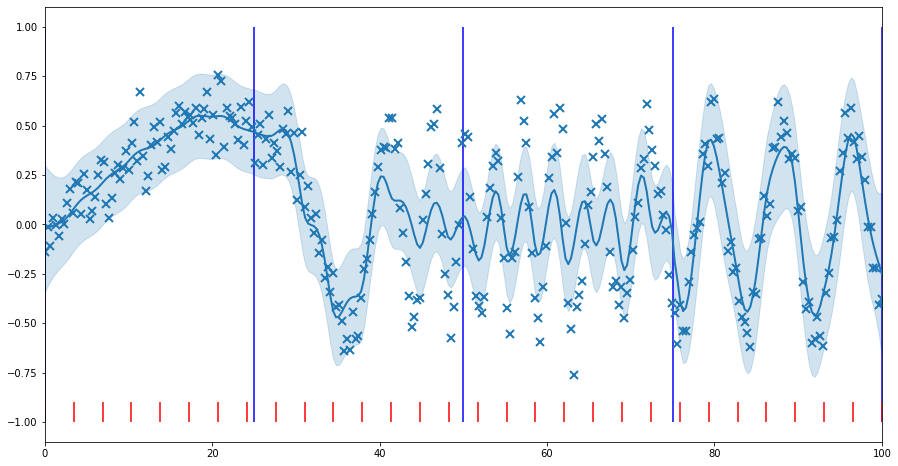

Iteration: 440 , Loss: 82.91239664840502


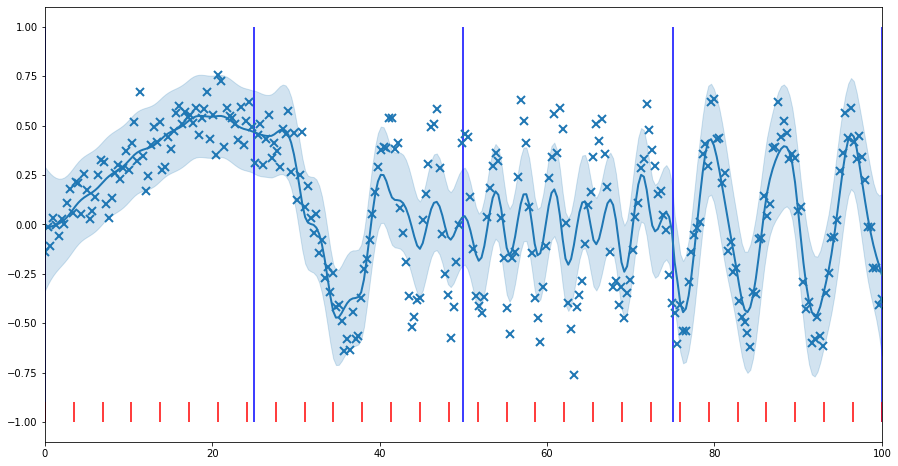

Iteration: 450 , Loss: 78.16035532466704


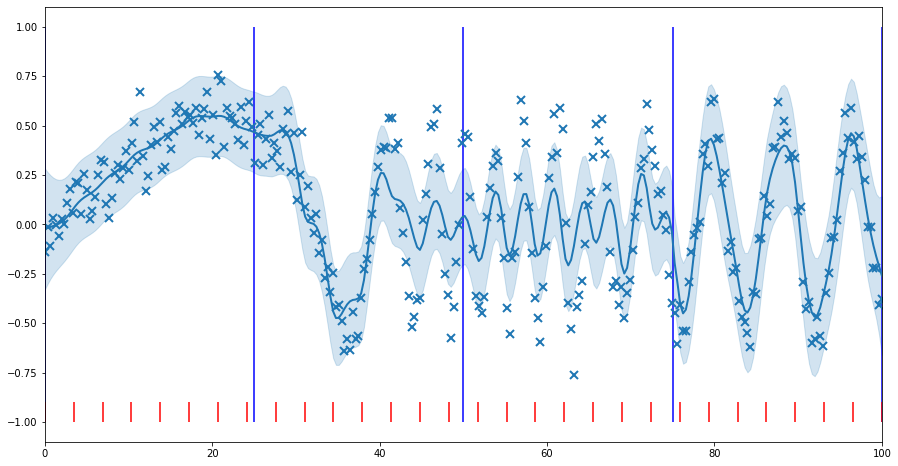

Iteration: 460 , Loss: 73.39565087175617


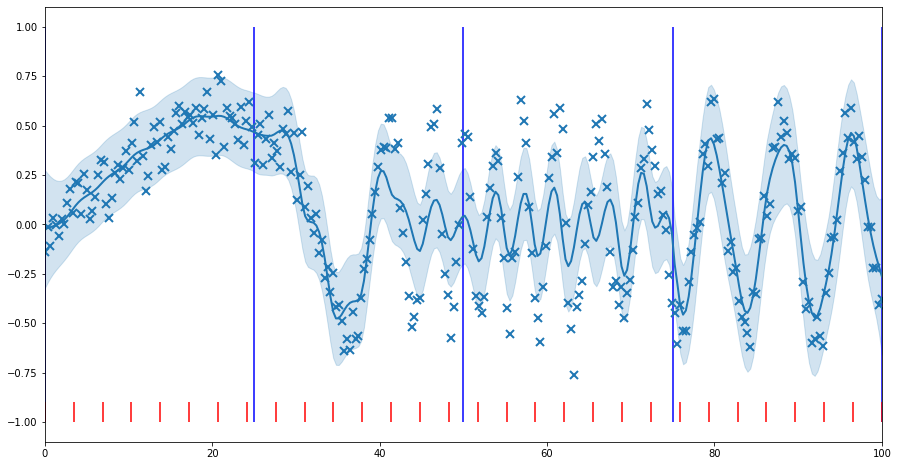

Iteration: 470 , Loss: 68.63150700289388


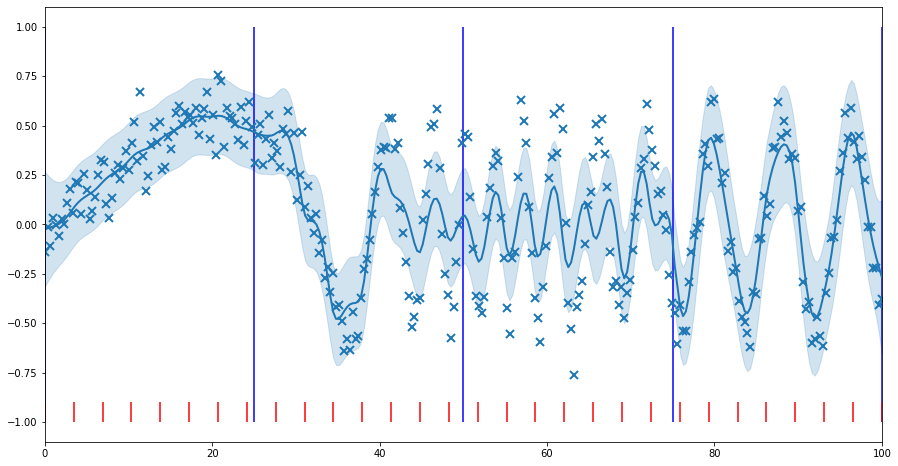

Iteration: 480 , Loss: 63.83577330777081


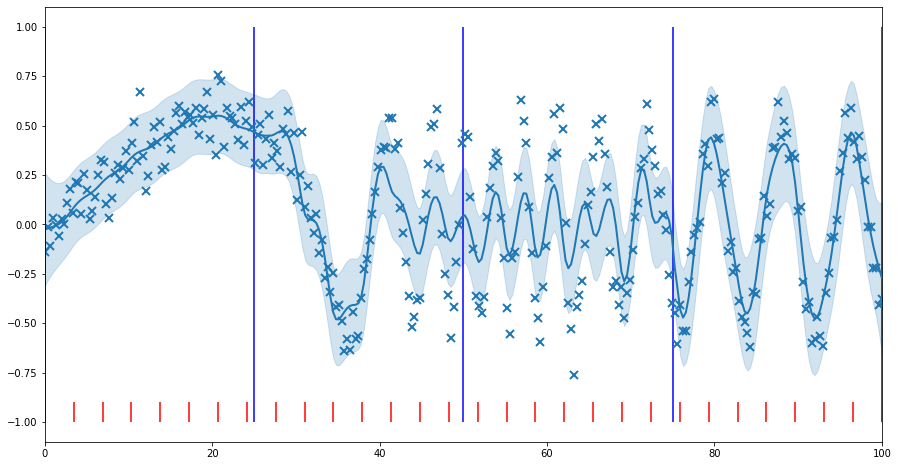

Iteration: 490 , Loss: 59.01067313197379


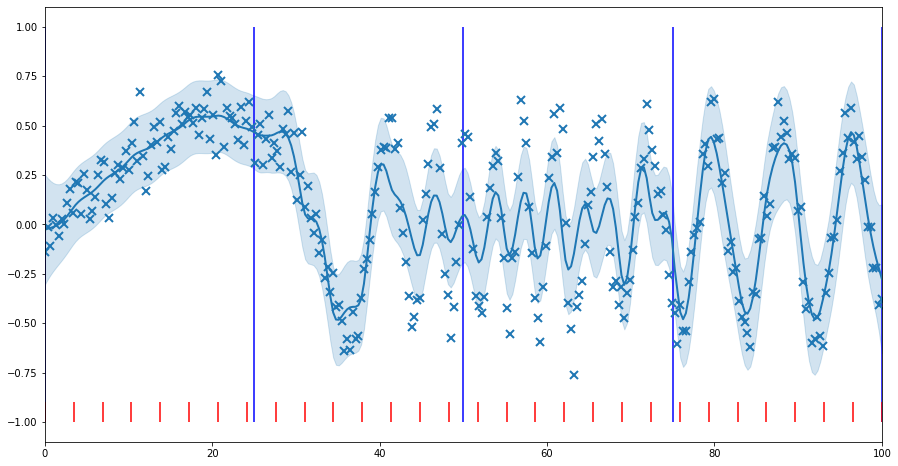

Loss after optimisation:  54.536794585358486


In [6]:
# Start at a small learning rate 
adam_learning_rate = 0.005
natgrad_learning_rate = .9
max_iter = ci_niter(500)

adam_opt = tf.optimizers.Adam(learning_rate=adam_learning_rate)
natgrad_opt = SSMNaturalGradient(gamma=natgrad_learning_rate, momentum=False)
set_trainable(s2vgp.dist_q, False)
adam_var_list = s2vgp.trainable_variables
set_trainable(s2vgp.dist_q, True)


@tf.function
def loss(input_data):
    return -s2vgp.elbo(input_data)


@tf.function
def opt_step(input_data):
    natgrad_opt.minimize(lambda : loss(input_data), s2vgp.dist_q)
    adam_opt.minimize(lambda : loss(input_data), adam_var_list)

def plot_model(s2vgp):
    pred = s2vgp.posterior
    latent_mean, latent_var = pred.predict_f(tf.constant(time_points))
    predicted_mean, predicted_cov = latent_mean.numpy(), latent_var.numpy()
    # Plot the means and covariances for these future time points
    fig, ax = plt.subplots(1, 1)
    ax.plot(time_points, observations, 'C0x', ms=8, mew=2)

    ax.plot(time_points, predicted_mean, 'C0', lw=2)
    ax.fill_between(time_points,
                     predicted_mean[:, 0] - 2 * np.sqrt(predicted_cov[:, 0]),
                     predicted_mean[:, 0] + 2 * np.sqrt(predicted_cov[:, 0]),
                     color='C0', alpha=0.2)

    cp = s2vgp.kernel.change_points.numpy()
    ax.vlines(cp, ymin=-1, ymax=1, colors='blue', label='change points')
    z_ = s2vgp.inducing_inputs.numpy()
    ax.vlines(z_, ymin=-1, ymax=-.9, colors='red', label='inducing points')

    ax.set_xlim((0., 100.))
    ax.set_ylim((-1.1, 1.1))
    return fig
    # plt.show()


for i in range(max_iter):
    opt_step(input_data)
    if i % 10 == 0:
        print("Iteration:", i, ", Loss:", s2vgp.loss(input_data).numpy())
        fig = plot_model(s2vgp)
        plt.show()

print("Loss after optimisation: ", s2vgp.loss(input_data).numpy())

# Save our trained hyperparamters (these will be used in Step 8)
saved_hyperparams = kernel.trainable_variables

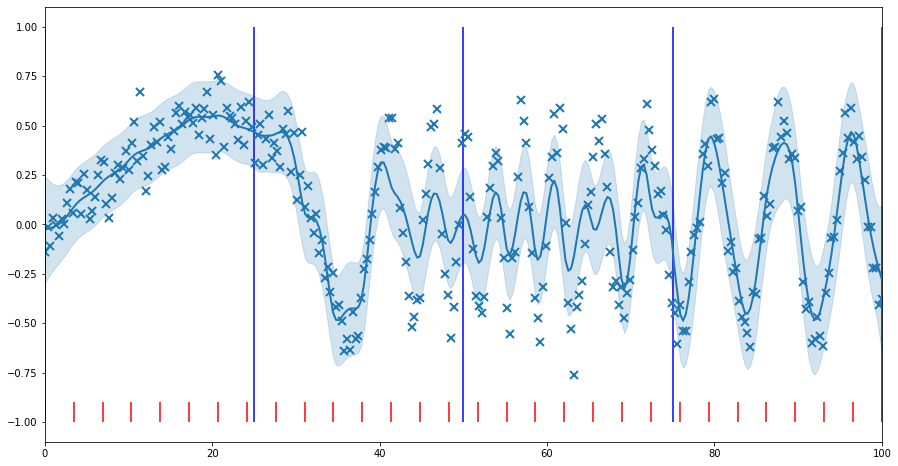

In [7]:
fig = plot_model(s2vgp)

We can see how our kernel parameters have changed from our initial values. 

In [8]:
gpflow.utilities.print_summary(s2vgp._kernel)

╒═════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════════════════╕
│ name                                    │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │ value                                 │
╞═════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════════════════╡
│ PiecewiseKernel.kernels[0]._state_mean  │ Parameter │ Identity    │         │ True        │ (3,)    │ float64 │ [0. 0. 0.]                            │
├─────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────────────────────────┤
│ PiecewiseKernel.kernels[0]._lengthscale │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 4.000000000008629                     │
├─────────────────────────────────────────┼───────────┼─────────────┼───────